In [1]:
from compute import args_in_order, Equation, coupled_run, buildidpvars
from inputresolver import reassign, getdofs, set_ins, mdf_order, possible_outputs, getallvars, invert_edges, resolve
from compute_utils import get_outputs, check_eqs
from representations import bipartite_repr, drawbipartite, digraph_repr, draw
import openmdao.api as om
import sympy as sp
import numpy as np
import networkx as nx
import gurobipy as gp
from gurobipy import GRB

Unable to import mpi4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.


In [2]:
x, z1, z2, y1, y2, f = sp.symbols("x z1 z2 y1 y2 f")
eqs = {
    4: (y1, z1**2+z2+x-0.2*y2),
    5: (y2, y1**0.5+z1+z2),
    6: (f, x**2+z1+y1+sp.exp(-y2)),
}
default_output = {key: left for key,(left,right) in eqs.items()}
eqvars = {key: right.free_symbols | left.free_symbols for key,(left,right) 
    in eqs.items()}

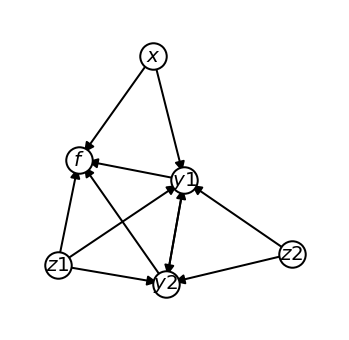

In [3]:
D, _ = digraph_repr(eqvars, default_output)
draw(D, prog='dfp')

In [4]:
G, edges_original = bipartite_repr(eqvars)

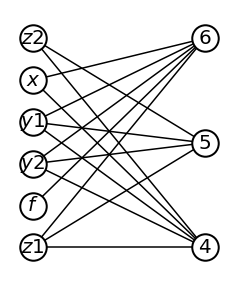

In [5]:
drawbipartite(G)

In [6]:
vrs = getallvars(eqs)
eqns = eqs.keys()
edges = invert_edges(edges_original)

In [9]:
sol = resolve(eqns, vrs, edges, 7)

C [{z1, 4, 5, 6, y1, z2}]
1 0.0 [3.0]
C []
2 0.0 []
C [{y2, 4, 5, y1}]
3 1.0 [2.0]
C []
4 1.0 []
C [{z1, 4, 5, 6, x, y2}]
5 1.0 [3.0]
C [{y2, 4, 5, z2}]
6 1.0 [2.0]
C []
7 1.0 []


In [10]:
sol

[(4, x), (5, y1), (6, f)]

In [42]:
dependentvars = [vr for eq,vr in sol]
inputs = [var for var in vrs if var not in dependentvars]
inputs

[y2, z1, z2]

In [43]:
new_eqs=reassign(eqs, dict(sol))
new_eqs

{4: (x, y1 + 0.2*y2 - z1**2 - z2),
 5: (y1, (-y2 + z1 + z2)**2),
 6: (f, x**2 + y1 + z1 + exp(-y2))}

In [44]:
dict(sol)

{4: x, 5: y1, 6: f}

In [45]:
eqvars

{4: {x, y1, y2, z1, z2}, 5: {y1, y2, z1, z2}, 6: {f, x, y1, y2, z1}}

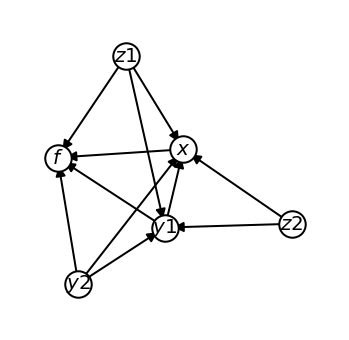

In [46]:
D, _ = digraph_repr(eqvars, dict(sol))
draw(D, prog='fdp')

In [47]:
ins = getdofs(eqs)
new_ins = getdofs(new_eqs)

In [48]:
ins, new_ins

({x, z1, z2}, {y2, z1, z2})

In [49]:
default_output

{4: y1, 5: y2, 6: f}

In [50]:
order = mdf_order(eqvars, default_output)
new_order = mdf_order(eqvars, dict(sol))

In [51]:
order, new_order

([(4, 5), 6], [5, 4, 6])

In [35]:
prob = om.Problem()
model = prob.model
counter = coupled_run(new_eqs, new_order, (), model, model, 0)
buildidpvars(new_ins, model)
prob.setup()
prob.run_model()

In [38]:
prob.set_val('y2', 9.834)
prob.set_val('z1', 2)
prob.set_val('z2', 5)
prob.run_model()

In [39]:
out = get_outputs(new_eqs, model)
print(out)

{f: 11.02832430067189, y1: 8.031555999999998, z1: 2.0, z2: 5.0, x: 0.9983559999999976, y2: 9.834}


In [34]:
out = get_outputs(new_eqs, model)
print(out)

{f: 11.03319755287768, y1: 8.033143969955152, z1: 2.0, z2: 5.0, x: 1.0, y2: 9.834280150224242}


In [40]:
check_eqs(new_eqs, out)

{4: (0.9983559999999976, 0.998355999999998),
 5: (8.031555999999998, 8.03155600000000),
 6: (11.02832430067189, 11.0283243006719)}